# Assignment 5 - Prediction of Used Car Prices

I, Mohammad El Tayech, affirm that I completed this assignment on my own without receiving or giving any help.

# **I - Baseline System**

After importing the necessary libraries and the data, some data-preprocessing and feature extraction needed to be done in order to build a linear regression model. First, I dropped all features that I thought were unnecessary in determining the price of a used car. Following this, I imputed missing values for numeric features with the median of the respective features.

One pre-processing step I carried out was converting the 'cylinders' feature from a categorical feature to a numeric feature. To do so, I also had to drop records with a 'cylinder' value of "other" and convert the new feature create from a string to an integer.

Outliers were then dropped fron numeric features. This was done to remove any extreme or impossible values (e.g.: a car cannot be sold for a negative price or for free).

After this, I imputed all categorical variables so that there would be no records with null values. After imputation, I encoded the categorical features to become numeric. Only one categorical feature ('condition') was encoded using ordinal encoding; the remaining categorical features were encoded using one-hot encoding.

The final stage in pre-processing was scaling the numeric features, which were scaled using the StandardScaler.

In the end, a linear regression model yielded an RMSE value of around 7779 with a standard deviation of 22.

## Importing Libraries and Data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeRegressor

In [2]:
train = pd.read_csv("https://raw.githubusercontent.com/motayech/Portfolio/main/Used%20Car%20Price%20Prediction/cars_train.csv")

In [3]:
train = train.reset_index(drop=True)

In [4]:
train.head(), train.shape

(           id           region  price    year manufacturer  \
 0  7226069143     indianapolis   3495  2005.0      lincoln   
 1  7233322668  medford-ashland  11995  2011.0       subaru   
 2  7239134076           austin  68990  2016.0      porsche   
 3  7238509078           hawaii  17900  2011.0          bmw   
 4  7236364831    daytona beach   9500  2006.0          NaN   
 
                  model  condition    cylinders fuel  odometer transmission  \
 0                  lse       good  8 cylinders  gas  181000.0    automatic   
 1              impreza       good  4 cylinders  gas   69408.0    automatic   
 2  cayman gts coupe 2d       good          NaN  gas    7923.0    automatic   
 3                 535i        NaN          NaN  gas   50193.0    automatic   
 4         mazada miata  excellent  4 cylinders  gas   52864.0    automatic   
 
   drive         type paint_color state        lat        long  \
 0   rwd        sedan      silver    in  39.640500  -86.311800   
 1   4wd    

## Data Pre-Processing

In [5]:
train.columns

Index(['id', 'region', 'price', 'year', 'manufacturer', 'model', 'condition',
       'cylinders', 'fuel', 'odometer', 'transmission', 'drive', 'type',
       'paint_color', 'state', 'lat', 'long', 'posting_date'],
      dtype='object')

In [6]:
train1 = train.copy()

In [7]:
train = train.drop(['id', 'region', 'model', 'lat', 'long', 'posting_date', 'manufacturer', 'state', 'paint_color'], axis=1)

In [8]:
train.columns

Index(['price', 'year', 'condition', 'cylinders', 'fuel', 'odometer',
       'transmission', 'drive', 'type'],
      dtype='object')

### Imputing Missing Values in the "Year" Feature

In [9]:
train['year'] = train['year'].fillna(train['year'].median())

### Imputing Missing Values in the "Odometer" Feature

In [10]:
train['odometer'] = train['odometer'].fillna(train['odometer'].median())

### Changing Data Type of "Cylinders" & Imputing for Missing Values of "Cylinders"

In [11]:
new_train = train['cylinders'].str.split(" ", n=1, expand=True)
train['num_cylinders'] = new_train[0] 
train.drop(columns =['cylinders'], inplace = True)

train = train[train['num_cylinders'] != 'other']

train['num_cylinders'] = train['num_cylinders'].fillna('2')

train['num_cylinders'] = train['num_cylinders'].astype(str).astype(int)

### Dropping Outliers for the "Price" Feature

In [12]:
print(train.shape)

(319998, 9)


In [13]:
Q1_train_price = train['price'].quantile(0.25)
Q3_train_price = train['price'].quantile(0.75)
IQR_train_price = Q3_train_price - Q1_train_price

train = train[(train['price'] > Q1_train_price - 1.5 * IQR_train_price) & (train['price'] < Q3_train_price + 1.5 * IQR_train_price)]
train = train[train['price'] > 0]

print(train.shape)

(287659, 9)


### Dropping Outliers for the "Odometer" Feature

In [14]:
Q1_train_odo = train['odometer'].quantile(0.25)
Q3_train_odo = train['odometer'].quantile(0.75)
IQR_train_odo = Q3_train_odo - Q1_train_odo

train = train[(train['odometer'] > Q1_train_odo - 1.5 * IQR_train_odo) & (train['odometer'] < Q3_train_odo + 1.5 * IQR_train_odo)]
train = train[train['odometer'] >= 0]

print(train.shape)

(283738, 9)


### Imputing Values for Categorical Features

In [15]:
train_cat = ['condition', 'fuel', 'transmission', 'drive', 'type']
train_cat_not_ordinal = ['fuel', 'transmission', 'drive', 'type']

In [16]:
def impute_nan_most_frequent_category(df, col_name):
     most_frequent_category = df[col_name].mode()[0]
     df[col_name].fillna(most_frequent_category,inplace=True)

for col in train_cat:
  impute_nan_most_frequent_category(train, col)


# Reference: https://medium.com/analytics-vidhya/ways-to-handle-categorical-column-missing-data-its-implementations-15dc4a56893

In [17]:
train.isnull().sum()

price            0
year             0
condition        0
fuel             0
odometer         0
transmission     0
drive            0
type             0
num_cylinders    0
dtype: int64

In [18]:
train = pd.get_dummies(train, columns=train_cat_not_ordinal)

train["condition"] = train["condition"].astype('category')

train["condition"] = train["condition"].cat.codes

### Scaling Numeric Features

In [19]:
ss = StandardScaler()
train[['year', 'odometer']] = ss.fit_transform(train[['year', 'odometer']])
train.head()

,price,year,condition,odometer,num_cylinders,fuel_diesel,fuel_electric,fuel_gas,fuel_hybrid,fuel_other,...,type_coupe,type_hatchback,type_mini-van,type_offroad,type_other,type_pickup,type_sedan,type_truck,type_van,type_wagon
0,3495,-0.621271,2,1.615288,8,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
1,11995,0.059855,2,-0.427465,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,17900,0.059855,2,-0.779207,2,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,9500,-0.507750,0,-0.730312,4,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
5,4300,-0.280708,2,-0.091394,8,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


## LR Model

In [20]:
train.isnull().sum()

price                     0
year                      0
condition                 0
odometer                  0
num_cylinders             0
fuel_diesel               0
fuel_electric             0
fuel_gas                  0
fuel_hybrid               0
fuel_other                0
transmission_automatic    0
transmission_manual       0
transmission_other        0
drive_4wd                 0
drive_fwd                 0
drive_rwd                 0
type_SUV                  0
type_bus                  0
type_convertible          0
type_coupe                0
type_hatchback            0
type_mini-van             0
type_offroad              0
type_other                0
type_pickup               0
type_sedan                0
type_truck                0
type_van                  0
type_wagon                0
dtype: int64

In [21]:
train.shape

(283738, 29)

In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283738 entries, 0 to 320748
Data columns (total 29 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   price                   283738 non-null  int64  
 1   year                    283738 non-null  float64
 2   condition               283738 non-null  int8   
 3   odometer                283738 non-null  float64
 4   num_cylinders           283738 non-null  int32  
 5   fuel_diesel             283738 non-null  uint8  
 6   fuel_electric           283738 non-null  uint8  
 7   fuel_gas                283738 non-null  uint8  
 8   fuel_hybrid             283738 non-null  uint8  
 9   fuel_other              283738 non-null  uint8  
 10  transmission_automatic  283738 non-null  uint8  
 11  transmission_manual     283738 non-null  uint8  
 12  transmission_other      283738 non-null  uint8  
 13  drive_4wd               283738 non-null  uint8  
 14  drive_fwd           

In [23]:
X = train.drop(['price'], axis=1)
y = train[['price']]

In [24]:
print(X.shape)
print(y.shape)

(283738, 28)
(283738, 1)


In [25]:
lr = LinearRegression()

scores = cross_val_score(lr, X, y, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(scores)))
print(np.std(np.absolute(scores)))

7779.168605889323
22.066990575250543


# **II - Feature Engineering**

At this stage, further pre-processing is done to lower the RMSE. Here, I added two features to the model: the 'paint_color' feature and the 'state' feature. First, I added the 'paint_color' feature and realized that the RMSE decreased. When I added the 'state' feature, it decreased further. 

I also tried adding the 'manufacturer' feature to the model; however, it resulted in an extremely high RMSE. Despite this, I thought that the 'manufacturer' feature was an important feature when buying a used car. To include the 'manufacturer' feature without significantly increasing the RMSE, I created a new feature called 'is_luxury', which is equal to 1 if the manufacturer is considered to be a luxury brand, and 0 otherwise. The selection of luxury brands was done through research and general knowledge (e.g.: Ferrari and Mercedes-Benz are well-known luxury brands). Adding the feature slightly decreased the RMSE. 

I also tried adding the 'region' and 'model' features separate times with failure due to them requiring a large amount of processing power. I thought it would be best to omit these two features from the model since the features are too detailed in my opinion, and a one-hot encoding of those features would dramatically increase the number of features which isn't good for the model.

Similar pre-processing techniques done in the first stage (imputation of missing values, removal of outliers, changing the data type of the 'cylinders' feature, etc.) were also done in this stage. Unlike the first stage, however, a QuantileTransformer was used to scale the numeric features instead of the StandardScaler. The QuantileTransformer decreased the RMSE.

In the end, the RMSE approximately decreases t around 6,685 with a standard deviation of around 8.7 (a 14% decrease compared to the first RMSE of 7,779).

In [26]:
# Dropping Columns
train1 = train1.drop(['id', 'region', 'lat', 'long', 'posting_date', 'model'], axis=1)

# Creating the "Age" Feature
train1['car_age'] = 2020 - train1['year']
train1 = train1.drop(['year'], axis = 1)

# Changing the Data Type of "Cylinders" & Imputing Missing Values
new_train1 = train1['cylinders'].str.split(" ", n=1, expand=True)
train1['num_cylinders'] = new_train1[0] 
train1.drop(columns =['cylinders'], inplace = True)

train1 = train1[train1['num_cylinders'] != 'other']
train1['num_cylinders'] = train1['num_cylinders'].fillna('6')
train1['num_cylinders'] = train1['num_cylinders'].astype(str).astype(int)

# Dropping Outliers from "Price" Feature
Q1_train1_price = train1['price'].quantile(0.25)
Q3_train1_price = train1['price'].quantile(0.75)
IQR_train1_price = Q3_train1_price - Q1_train1_price

train1 = train1[(train1['price'] > Q1_train1_price - 1.5 * IQR_train1_price) & (train1['price'] < Q3_train1_price + 1.5 * IQR_train1_price)]
train1 = train1[train1['price'] > 0]

# Dropping Outliers from the "Odometer" Feature
Q1_train1_odo = train1['odometer'].quantile(0.25)
Q3_train1_odo = train1['odometer'].quantile(0.75)
IQR_train1_odo = Q3_train1_odo - Q1_train1_odo

train1 = train1[(train1['odometer'] > Q1_train1_odo - 1.5 * IQR_train1_odo) & (train1['odometer'] < Q3_train1_odo + 1.5 * IQR_train1_odo)]
train1 = train1[train1['odometer'] > 0]

# Adding "Is Luxury?" Category (from "Manufacturer" category)
lux = ['bmw', 'mercedes-benz', 'chrysler', 'lexus', 'cadillac', 'buick', 'audi', 'acura', 'infiniti', 'lincoln', 'volvo', 'mini', 'porsche', 'saturn',
       'jaguar', 'tesla', 'alfa-romeo', 'land rover', 'aston-martin', 'hennessey', 'ferrari']
x = list(train1['manufacturer'])
y = []

for car in x:
  if car in lux:
    y.append(1)
  else:
    y.append(0)

y = pd.Series(y)
train1['is_luxury'] = y.values

train1 = train1.drop(['manufacturer'], axis = 1)

# Adding the "Region" Category (from "State" Category)
northeast = ['ct', 'me', 'ma', 'nh', 'ri', 'vt', 'nj', 'ny', 'pa']
midwest = ['il', 'in', 'mi', 'oh', 'wi', 'ia', 'ks', 'mn', 'mo', 'ne', 'nd', 'sd']
south = ['de', 'fl', 'ga', 'md', 'nc', 'sc', 'va', 'dc', 'wv', 'al', 'ky', 'ms', 'tn', 'ar', 'la', 'ok', 'tx']
west = ['az', 'co', 'id', 'mt', 'nv', 'nm', 'ut', 'wy', 'ak', 'ca', 'hi', 'or', 'wa']

ne_list = []
mw_list = []
south_list = []
west_list = []

for state in list(train1['state']):
  if state in northeast:
    ne_list.append(1)
  else:
    ne_list.append(0)
  
  if state in midwest:
    mw_list.append(1)
  else:
    mw_list.append(0)
  
  if state in south:
    south_list.append(1)
  else:
    south_list.append(0)

  if state in west:
    west_list.append(1)
  else:
    west_list.append(0)

ne_list = pd.Series(ne_list)
mw_list = pd.Series(mw_list)
south_list = pd.Series(south_list)
west_list = pd.Series(west_list)

train1['state_region_northeast'] = ne_list.values
train1['state_region_midwest'] = mw_list.values
train1['state_region_south'] = south_list.values
train1['state_region_west'] = west_list.values

train1 = train1.drop(['state'], axis = 1)

# Imputing Missing Values for Categorical Features
train1_cat = ['condition', 'fuel', 'transmission', 'drive', 'paint_color', 'type']
train1_cat_not_ordinal = ['fuel', 'transmission', 'drive', 'paint_color', 'type']

for col1 in train1_cat:
  impute_nan_most_frequent_category(train1, col1)

########################################
train3 = train1.copy()
########################################

# Imputing Missing Values for Numeric Features
train1['car_age'] = train1['car_age'].fillna(train1['car_age'].median())
train1['odometer'] = train1['odometer'].fillna(train1['odometer'].median())
train1['num_cylinders'] = train1['num_cylinders'].fillna(train1['num_cylinders'].median())

## Ordinal Encoding of Ordinal Categorical Features
train1["condition"] = train1["condition"].astype('category')
train1["condition"] = train1["condition"].cat.codes

## One-Hot Encoding of Non-Ordinal Categorical Features
train1 = pd.get_dummies(train1, columns=train1_cat_not_ordinal)

# Scaling Numeric Features
qt = QuantileTransformer()

train1[['car_age', 'odometer', 'num_cylinders']] = qt.fit_transform(train1[['car_age', 'odometer', 'num_cylinders']])
print(train1.head())

# LR Model - RMSE & Std. Deviation
X1 = train1.drop(['price'], axis=1)
y1 = train1[['price']]

########################################
X3 = X1.copy()
y3 = y1.copy()
########################################

scores1 = cross_val_score(lr, X1, y1, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(scores1)))
print(np.std(np.absolute(scores1)))

   price  condition  odometer   car_age  num_cylinders  is_luxury  \
0   3495          2  0.912478  0.858859       0.906406          1   
1  11995          2  0.379094  0.614114       0.116617          0   
3  17900          2  0.282659  0.614114       0.527528          1   
4   9500          0  0.295709  0.826326       0.116617          0   
6  29900          2  0.920921  0.396897       0.527528          0   

   state_region_northeast  state_region_midwest  state_region_south  \
0                       0                     1                   0   
1                       0                     0                   0   
3                       0                     0                   0   
4                       0                     0                   1   
6                       0                     1                   0   

   state_region_west  ...  type_coupe  type_hatchback  type_mini-van  \
0                  0  ...           0               0              0   
1             

# **III - Model Optimization and Selection**

Three different ML algorithms were used to decide on the optimal model (the one leading to the lowest RMSE). The models were: Decision Tree, Random Forest Regressor, and Gradient Boosting Regressor. The optimal values for hyperparameters of these algorithms were found using GridSearchCV. Due to time constraints, only two hyperparameters were optimized: the 'max_depth' hyperparameter and the 'max_features' hyperparameter. For the 'max_depth' feature, a value between 4 and 8 were tested for optimality; the maximum value of 12 is set to prevent overfitting. For 'max_features', the values tested were: ['sqrt', 0.25, 0.5, 0.75, 1]. In addition, two values of the hyperparameters were tested separate times, instead of the whole set of values to be tested at once to save time.

In the end, all three models yielded the same optimal values for hyperparameters, with an optimal 'max_depth' value of 12 and a 'max_features' value of 0.75.

Computation of the RMSE and the standard deviation found that all three models decreased the RMSE. However, the optimal model was found to be the Gradient Boosting Regressor, with an RMSE of around 4,878 and a standard deviation of around 13.

A LinearSVC model was also tested. However, due to high running time, it is not included in the code. The LinearSVC did not yield an optimal model.

## Decision Tree

In [27]:
dtr = DecisionTreeRegressor(random_state=42)

grid_values_dtr = {'max_depth': [10,12],
                  'max_features': ['sqrt', 0.75, 1]
                  }

grid_search_dtr = GridSearchCV(dtr, param_grid = grid_values_dtr, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
grid_search_dtr.fit(X1, y1)

grid_search_dtr.best_params_

{'max_depth': 12, 'max_features': 0.75}

## Random Forest Regressor

In [28]:
rfr = RandomForestRegressor(random_state=42)

grid_values_rfr = {'max_depth': [10,12],
                  'max_features': ['sqrt', 0.75, 1]
                  }

grid_search_rfr = GridSearchCV(rfr, param_grid = grid_values_rfr, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
grid_search_rfr.fit(X1, y1)

grid_search_rfr.best_params_

C:\Users\motay\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 12, 'max_features': 0.75}

## Gradient Boosting Regressor

In [29]:
gbr = GradientBoostingRegressor(random_state=42)

grid_values_gbr = {'max_depth': [10,12],
                  'max_features': ['sqrt', 0.75, 1]
                  }

grid_search_gbr = GridSearchCV(gbr, param_grid = grid_values_gbr, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
grid_search_gbr.fit(X1, y1)

grid_search_gbr.best_params_

C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


{'max_depth': 12, 'max_features': 0.75}

## RMSE & Standard Deviation Computation

In [30]:
# Decision Tree
dtr_optimal = grid_search_dtr.best_estimator_

scores_dtr = cross_val_score(dtr_optimal, X1, y1, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(scores_dtr)))
print(np.std(np.absolute(scores_dtr)))

5848.171835837777
20.974374691327064


In [31]:
# Random Forest
rfr_optimal = grid_search_rfr.best_estimator_

scores_rfr = cross_val_score(rfr_optimal, X1, y1, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(scores_rfr)))
print(np.std(np.absolute(scores_rfr)))

C:\Users\motay\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:531: DataConversionWarning: A column-vector y wa

5489.994943473893
15.940041904844131


In [32]:
# Gradient Boosting
gbr_optimal = grid_search_gbr.best_estimator_

scores_gbr = cross_val_score(gbr_optimal, X1, y1, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(scores_gbr)))
print(np.std(np.absolute(scores_gbr)))

C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**

4877.90129747964
13.253602154625208


# **IV- Feature Selection**

To compute the important features in our model, the feature importances must be calculated. To do so, I instantiated the target label and the target features on our optimal Random Forest Regressor model. Following this, it was possible to graph the importance of features. Some key important features were 'car_age', 'odometer', and 'num_cylinders'. What surprised me here is the importance of the 'condition' feature; while still important, it was less than I thought it would be.

In addition to the following, I computed feature importances using RFECV (not included in the code due to high running time), which yielded similar results to .feature_importances_.

Unimportant features that were dropped included some of the 'paint_color' features (such as brown and purple cars (this makes sense because they're ugly colors for cars in my opinion)) as well as some of the 'type' features (such as buses (buses are not vehicles one can normally drive)).

10 features were dropped out of 45 (i.e. there are now 35 features in the model). Dropping the features led to a 22% decrease in the number of features.

After dropping these features, the RMSE decreased by approzimately 0.55% compared to the original Gradient Boosting Regressor RMSE.

## Using .feature_importances_

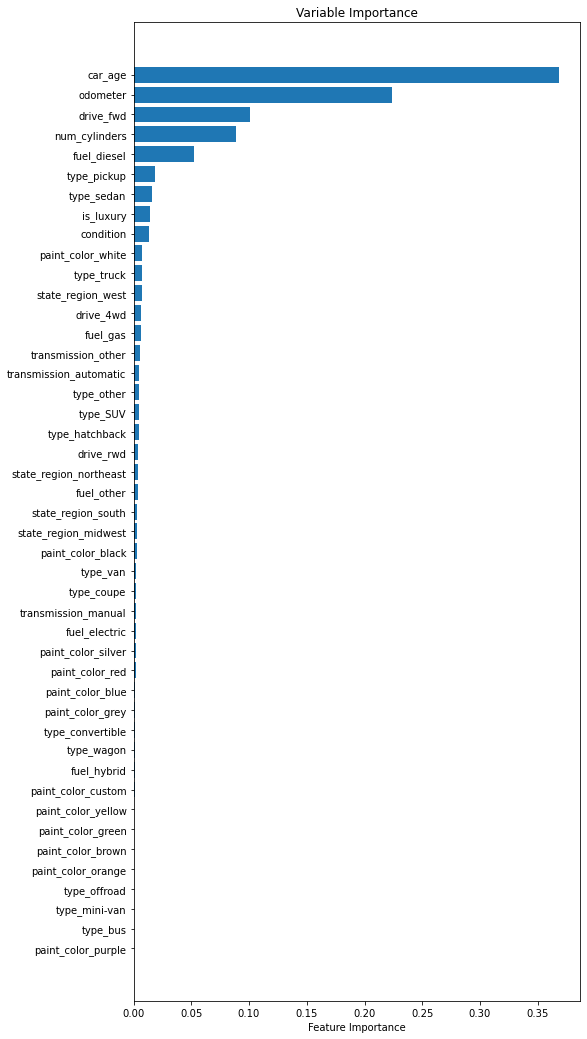

In [33]:
feature_importance = gbr_optimal.feature_importances_

sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(8, 18))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X1.keys()[sorted_idx])
plt.xlabel('Feature Importance')
plt.title('Variable Importance')
plt.show()

# Reference: https://stackoverflow.com/questions/24255723/sklearn-logistic-regression-important-features

In [34]:
feature_extraction = pd.DataFrame({'feature': np.array(X1.columns), 'importance': gbr_optimal.feature_importances_})
feature_extraction

,feature,importance
0,condition,0.013452
1,odometer,0.223446
2,car_age,0.368136
3,num_cylinders,0.088997
4,is_luxury,0.014442
5,state_region_northeast,0.004041
6,state_region_midwest,0.002962
7,state_region_south,0.002966
8,state_region_west,0.007326
9,fuel_diesel,0.052186


## Computation of RMSE & Standard Deviation after Removal of Unimportant Features

In [35]:
train2 = train1
train2 = train2.drop(columns=['paint_color_brown', 'paint_color_custom', 'paint_color_green', 'paint_color_orange', 'paint_color_purple', 'paint_color_yellow', 'type_bus', 'type_offroad', 'type_mini-van', 'type_wagon'], axis=1)

X2 = train2.drop(columns=['price'], axis=1)
y2 = train2['price']

new_gbr_score = cross_val_score(gbr_optimal, X2, y2, scoring = 'neg_root_mean_squared_error', cv = 5)

print(np.mean(np.absolute(new_gbr_score)))
print(np.std(np.absolute(new_gbr_score)))

4850.606273083307
11.011257906337537


# **V - Pipeline, Interpretable Model, and Final Testing**

The pipeline created here only imputes missing values for numeric features and encodes the categorical features. This is the case due to the fact that many features were created in the pre-processing stage (Part II) that cannot otherwise be created using the Pipeline. Moreover, the imputing of categorical features in the pre-processing stage was done using a manual Python function. In the numeric pipeline, the SimpleImputer is used to impute missing numeric values and the QuantileTransformer is used to scale the data. This numeric pipeline was then implemented in a full pipeline that conducts both the ordinal encoding and one-hot encoding of categorical values.

After creating the pipeline, I tried optimizing the hyperparameters for the DecisionTreeRegressor, since it is an interpretable model along with the linear regression using the Pipeline.

After applying the pre-processing techniques and the pipeline to the test set, the model was evaluated using the interpretable models (Linear Regression & Decision Tree) and the optimal Gradient Boosting Regressor in Part III. In the end, the Gradient Boosting Regressor yielded the lowest RMSE of around 5,334.

#### Would collecting more data and retraining the model decrease the error rate of our system?

It depends. To know whether the addition of new data to the training set leads to a decrease in the error when evaluating on the test, we need to compute both training error and test error. If there is low training error but high testing error (the model does not work well on new data), then there is a case of overfitting. In this case, the addition of data is advantageous to reduce overfitting and to work well on new data.

However, should new data be added to the training set, it should be consistent with all other records. For example, in the case of predicting the price of used cars, a record cannot contain a significantly high or negative price; it must be consistent with the data already present. If this is not the case, then the model cannot predict on new data.

In addition, if there is already a high amount of records in the training set, then the addition of new records would not change the error; it would remain somewhat constant. There is always bound to be some error in the model (no model is perfect). There reaches a point where the addition of data has little to no effect on the error.

## Creating Training Pipelines

In [36]:
num_pipeline_train = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('qr', QuantileTransformer()),
    ])

train_numeric = train3[['car_age', 'odometer', 'num_cylinders']]
train_categorical_nonordinal = train3[['fuel', 'transmission', 'drive', 'type', 'paint_color']]
train_categorical_ordinal = train3[['condition']]

num_attribs = list(train_numeric)
cat_nonordinal_attribs = list(train_categorical_nonordinal)
cat_ordinal_attribs = list(train_categorical_ordinal)

full_pipeline_train = ColumnTransformer([
        ("num", num_pipeline_train, num_attribs),
        ("cat_nonordinal", OneHotEncoder(), cat_nonordinal_attribs),
        ("cat_ordinal", OrdinalEncoder(), cat_ordinal_attribs),
    ])

train_prepared = full_pipeline_train.fit_transform(train3)

In [37]:
train_prepared = train_prepared.toarray()

scores_linear_pipeline = cross_val_score(lr, train_prepared, y3, scoring = 'neg_root_mean_squared_error', cv=5)

print(np.mean(np.absolute(scores_linear_pipeline)))
print(np.std(np.absolute(scores_linear_pipeline)))

6723.9604807199385
9.241703977451367


## Optimizing Hyperparameters of Interpretable Model (Linear Regression & Decision Tree)

In [41]:
pipe = Pipeline([('model', LinearRegression())])

grid_param = [
                {"model": [DecisionTreeRegressor()],
                 "model__min_samples_split": [10, 20],
                 "model__max_depth": [10, 12],
                 "model__min_samples_leaf": [20, 40],
                 "model__max_leaf_nodes": [50, 100],
                 'model__max_features': ['sqrt', 0.75, 1]
                }]

gridsearch = GridSearchCV(pipe, grid_param, cv=5, n_jobs=-1)
best_model = gridsearch.fit(train_prepared, y3)

## Pre-Processing on Test Set

In [43]:
test = pd.read_csv("https://raw.githubusercontent.com/motayech/Portfolio/main/Used%20Car%20Price%20Prediction/cars_test.csv")

In [44]:
# Dropping Columns
test = test.drop(['id', 'region', 'lat', 'long', 'posting_date', 'model'], axis=1)

# Creating the "Age" Feature
test['car_age'] = 2020 - test['year']
test = test.drop(['year'], axis = 1)

# Changing the Data Type of "Cylinders" & Imputing Missing Values
new_test = test['cylinders'].str.split(" ", n=1, expand=True)
test['num_cylinders'] = new_test[0] 
test.drop(columns =['cylinders'], inplace = True)

test = test[test['num_cylinders'] != 'other']
test['num_cylinders'] = test['num_cylinders'].fillna('6')
test['num_cylinders'] = test['num_cylinders'].astype(str).astype(int)

# Dropping Outliers from "Price" Feature
Q1_test_price = test['price'].quantile(0.25)
Q3_test_price = test['price'].quantile(0.75)
IQR_test_price = Q3_test_price - Q1_test_price

test = test[(test['price'] > Q1_test_price - 1.5 * IQR_test_price) & (test['price'] < Q3_test_price + 1.5 * IQR_test_price)]
test = test[test['price'] > 0]

# Dropping Outliers from the "Odometer" Feature
Q1_test_odo = test['odometer'].quantile(0.25)
Q3_test_odo = test['odometer'].quantile(0.75)
IQR_test_odo = Q3_test_odo - Q1_test_odo

test = test[(test['odometer'] > Q1_test_odo - 1.5 * IQR_test_odo) & (test['odometer'] < Q3_test_odo + 1.5 * IQR_test_odo)]
test = test[test['odometer'] > 0]

# Adding "Is Luxury?" Category (from "Manufacturer" category)
lux = ['bmw', 'mercedes-benz', 'chrysler', 'lexus', 'cadillac', 'buick', 'audi', 'acura', 'infiniti', 'lincoln', 'volvo', 'mini', 'porsche', 'saturn',
       'jaguar', 'tesla', 'alfa-romeo', 'land rover', 'aston-martin', 'hennessey', 'ferrari']
x = list(test['manufacturer'])
y = []

for car in x:
  if car in lux:
    y.append(1)
  else:
    y.append(0)

y = pd.Series(y)
test['is_luxury'] = y.values

test = test.drop(['manufacturer'], axis = 1)

# Adding the "Region" Category (from "State" Category)
northeast = ['ct', 'me', 'ma', 'nh', 'ri', 'vt', 'nj', 'ny', 'pa']
midwest = ['il', 'in', 'mi', 'oh', 'wi', 'ia', 'ks', 'mn', 'mo', 'ne', 'nd', 'sd']
south = ['de', 'fl', 'ga', 'md', 'nc', 'sc', 'va', 'dc', 'wv', 'al', 'ky', 'ms', 'tn', 'ar', 'la', 'ok', 'tx']
west = ['az', 'co', 'id', 'mt', 'nv', 'nm', 'ut', 'wy', 'ak', 'ca', 'hi', 'or', 'wa']

ne_list = []
mw_list = []
south_list = []
west_list = []

for state in list(test['state']):
  if state in northeast:
    ne_list.append(1)
  else:
    ne_list.append(0)
  
  if state in midwest:
    mw_list.append(1)
  else:
    mw_list.append(0)
  
  if state in south:
    south_list.append(1)
  else:
    south_list.append(0)

  if state in west:
    west_list.append(1)
  else:
    west_list.append(0)

ne_list = pd.Series(ne_list)
mw_list = pd.Series(mw_list)
south_list = pd.Series(south_list)
west_list = pd.Series(west_list)

test['state_region_northeast'] = ne_list.values
test['state_region_midwest'] = mw_list.values
test['state_region_south'] = south_list.values
test['state_region_west'] = west_list.values

test = test.drop(['state'], axis = 1)

# Imputing Missing Values for Categorical Features
test_cat = ['condition', 'fuel', 'transmission', 'drive', 'paint_color', 'type']
test_cat_not_ordinal = ['fuel', 'transmission', 'drive', 'paint_color', 'type']

for col1 in test_cat:
  impute_nan_most_frequent_category(test, col1)

## Creating Pipelines for Test Set

In [45]:
num_pipeline_test = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('qr', QuantileTransformer()),
    ])

test_numeric = test[['car_age', 'odometer', 'num_cylinders']]
test_categorical_nonordinal = test[['fuel', 'transmission', 'drive', 'type', 'paint_color']]
test_categorical_ordinal = test[['condition']]

num_attribs = list(test_numeric)
cat_nonordinal_attribs = list(test_categorical_nonordinal)
cat_ordinal_attribs = list(test_categorical_ordinal)

full_pipeline_test = ColumnTransformer([
        ("num", num_pipeline_test, num_attribs),
        ("cat_nonordinal", OneHotEncoder(), cat_nonordinal_attribs),
        ("cat_ordinal", OrdinalEncoder(), cat_ordinal_attribs),
    ])

X_test = test.drop(columns=['price'], axis=1)
y_test = test['price']

test_prepared = full_pipeline_test.fit_transform(X_test)
test_prepared = test_prepared.toarray()

## Evaluation of Models on Test Set

In [48]:
# Interpretable Model (Decision Tree)
y_pred = best_model.best_estimator_.predict(test_prepared)
np.sqrt(mean_squared_error(y_pred, y_test))

6494.393193461443

In [49]:
# Gradient Boosting Regressor
gb = grid_search_gbr.best_estimator_
gb

gb.fit(train_prepared, y3)
y_pred = gb.predict(test_prepared)
np.sqrt(mean_squared_error(y_pred, y_test))

C:\Users\motay\Anaconda3\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


5336.564873250225

In [50]:
# Linear Regression
lr.fit(train_prepared, y3)
y_pred = lr.predict(test_prepared)
np.sqrt(mean_squared_error(y_pred, y_test))

6735.160078305376

I, Mohammad El Tayech, affirm that I completed this assignment on my own without receiving or giving any help.